# 1. Making classification data
We'll generate some data to make two circles that our later model will attempt to binarily classify. 


In [1]:
from sklearn.datasets import make_circles

# Here we are just using a prebuilt dataset function to generate some (semi)random
# data
n_samples = 1000
x, y = make_circles(n_samples, noise=0.03, random_state=42)

# There are two x values per one y value
# where the x values are the coordinates of the circle and the y value is its binary classification
# (either a 1 or 0)
print(f"First 5 X features:\n{x[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


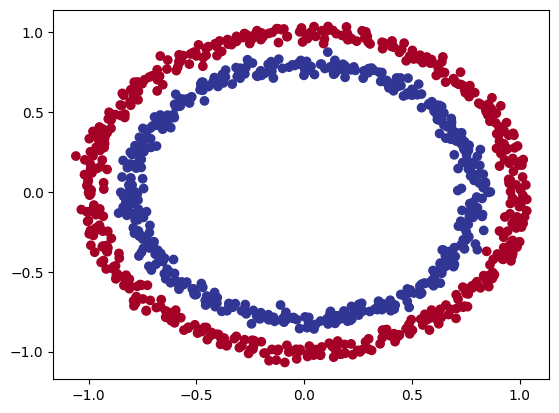

In [2]:
import matplotlib.pyplot as plt

plt.scatter(x=x[:, 0], y=x[:, 1], c=y, cmap=plt.cm.RdYlBu)

# Turn data into tensors
We now have to prepare the data so that it can be used within pytorch. We do this by converting the data into tensors (which are more easily usable with pytorch).
\
\
We then need to split our data into training and testing batches, just as we have done in other exercises. 

In [3]:
import torch

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [4]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# This just splits the data into sizes that we want. 
# the test size is 0.2, so that 20% of our data is for testing and the other 80% is for training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 2. Build a model
The following steps are all those that were covered in the previous module

In [5]:
import torch
from torch import nn

# Make the device agnostic code
# This is so that the code can run on the gpu if possible
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

We now want to generate a model that can handle ut x data as inputs and produce something in the shape of y as it's output. Therefore, the model given x features we want to predict y (a label)
\
\
We're going to have two a sinlge hidden layer and an output layer. The hidden layer will have 5 neurons and output to a single neuron. The initial input layer will have 2 neurons (corresponding to the input data) and output to the five neurons of the hidden layer.

In [6]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create the input and hidden layer of the network
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # we want to return the output of the second layer, whose shape is the same as y (a single
        # dimensional scalar)
        # We want to pass as input to the hidden layer, the activations of the input layer
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = CircleModelV0()
model

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

# Set up loss function and optimizer
There are quite a few different kinds of loss functions and optimizers that you can use and their usage is dependent on the kinds of problem that you are working with. 
\
\
Binary cross entropy is a typical loss function used for binary classification problems like this one. Additionally, there is a different kind of bce loss function that includes a sigmoid layer. 
\
\
BCE essentially penalizes outputs that are farther away from their true value. And this penalization increases logarithmically, so larger errors are penalized much more than closer errors

In [7]:
# Create a loss function for the network
loss_func = nn.BCEWithLogitsLoss() # this has a sigmoid layer built in

# Create an optimizer using Stochastic Gradient Descent
opt = torch.optim.SGD(params=model.parameters(), lr=0.1)

# Create evaluation metric
We will generate a function to measure the rate of accuracy of out model. We can do this by summing up all of the correct answers across a training set and dividing them by all of the total answers

In [8]:
def accuracy_func(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100

    return acc

# 3. Train the model
We now want to use our model, loss function and optimizer function to train the network on the given input data set.

In [9]:
torch.manual_seed(42)
epochs = 2000

# Switch the model to the gpu
model.to(device)

# Switch the data over the the gpu
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Make the initial forward pass through the network
    # calculate the logits
    # This function here creates some numbers that are not super readable to our accuracy funciton
    # we need to put the resulant output number into a number between 0-1 to classify in binarily
    # That is what the sigmoid function does
    y_logits = model(x_train).squeeze()
    # This here applies the sigmoid function to get a number between 0-1
    y_pred = torch.round(torch.sigmoid(y_logits))

    # We don't need to pass in the y_pred because out loss function has the sigmoid built into it
    loss = loss_func(y_logits, y_train)

    opt.zero_grad()
    loss.backward()
    opt.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(x_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_func(test_logits, y_test)
        test_acc = accuracy_func(y_true=y_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69920, Accuracy: 50.00% | Test Loss: 0.69849, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69278, Accuracy: 50.00% | Test Loss: 0.69344, Test Accuracy: 50.00%
Epoch: 200 | Loss: 0.69207, Accuracy: 48.00% | Test Loss: 0.69326, Test Accuracy: 48.00%
Epoch: 300 | Loss: 0.69102, Accuracy: 47.50% | Test Loss: 0.69295, Test Accuracy: 47.50%
Epoch: 400 | Loss: 0.68957, Accuracy: 47.50% | Test Loss: 0.69251, Test Accuracy: 47.50%
Epoch: 500 | Loss: 0.68755, Accuracy: 48.50% | Test Loss: 0.69190, Test Accuracy: 48.50%
Epoch: 600 | Loss: 0.68474, Accuracy: 48.00% | Test Loss: 0.69072, Test Accuracy: 48.00%
Epoch: 700 | Loss: 0.68080, Accuracy: 48.50% | Test Loss: 0.68844, Test Accuracy: 48.50%
Epoch: 800 | Loss: 0.67513, Accuracy: 49.00% | Test Loss: 0.68467, Test Accuracy: 49.00%
Epoch: 900 | Loss: 0.66693, Accuracy: 53.50% | Test Loss: 0.67868, Test Accuracy: 53.50%
Epoch: 1000 | Loss: 0.65479, Accuracy: 62.50% | Test Loss: 0.66898, Test Accuracy: 62.50%
Epoch: 1100 | Loss: 0.

# Evaluating the model


In [12]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

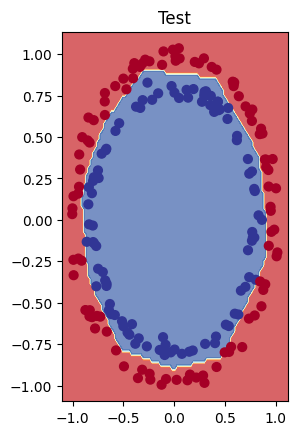

In [13]:
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)